## Winters, Alexander (V00970263)

# Problem 1. The American Handwriting

### Sources:

https://deepnotes.io/softmax-crossentropy

https://www.kdnuggets.com/2019/11/build-artificial-neural-network-scratch-part-1.html

https://www.kdnuggets.com/2020/03/build-artificial-neural-network-scratch-part-2.html

https://mlfromscratch.com/neural-network-tutorial/#/

https://www.youtube.com/watch?v=w8yWXqWQYmU

https://keras.io/api/

https://keras.io/examples/vision/mnist_convnet/

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

https://github.com/Soft-Squad/kNN-kMeans-Softmax/blob/main/src/softmax.py My work from CSC421

## 1.1 Derivative

Given the softmax function:
\begin{equation}
f(x)_i = \frac{e^{x_i}}{\sum_j e^{x_j}}
\end{equation}

The quotient rule $f(x) = \frac{g(x)}{h(x)}$ gives us: 

\begin{equation}
f'(x) = \frac{g'(x)h(x) - h'(x)g(x)}{h(x)^2}
\end{equation}

Where $g(x) = e^{x_i}$ and $h(x) = \sum_j e^{x_j}$

Thus, $h(x)$ will always be $e^{x_j}$

However, $g(x)$ will only be $e^{x_i}$ if $i=j$, otherwise it's $0$.

Hence,
If $i=j$,

\begin{align}
\frac{\partial  \frac{e^{x_i}}{\sum_k e^{x_k}}}{\partial x_j}&= \frac{e^{x_i} \sum_j e^{x_k} - e^{x_j}e^{x_i}}{\left( \sum_k e^{x_k}\right)^2} \\
&= \frac{e^{x_i} \left( \sum_k e^{x_k} - e^{x_j}\right )}{\left( \sum_k e^{x_k}\right)^2} \\
&= \frac{ e^{x_j} }{\sum_k e^{x_k} } \times \frac{\left( \sum_k e^{x_k} - e^{x_j}\right ) }{\sum_k e^{x_k} } \\
&= p_i(1-p_j)
\end{align}

For $i\neq j$,

\begin{align}
\frac{\partial  \frac{e^{x_i}}{\sum_k e^{x_k}}}{\partial x_j}&= \frac{0 - e^{x_j}e^{x_i}}{\left( \sum_k e^{x_k}\right)^2} \\
&= \frac{- e^{x_j} }{\sum_k e^{x_k} } \times \frac{e^{x_i} }{\sum_k e^{x_k} } \\
&= - p_j.p_i
\end{align}

Therefore, the derivative of the softmax function is,
\begin{align}
\frac{\partial p_i}{\partial a_j} = 
\begin{cases}p_i(1-p_j) &  if & i=j \\
-p_j.p_i & if & i \neq j
\end{cases}
\end{align}

or, 
\begin{align}
f'(x)_i= 
\begin{cases}
f(x)_i(1 - f(x)_i) & i = j\\-f(x)_if(x)_j & i \neq j
\end{cases}
\end{align}

# Note: You must run the 3 cells below, and then skip to 1.3 - 1.6. Next, run 1.2, and lastly run 1.7.

#### Problem: 
 I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
<br>
OMP: Error #15: Initializing libiomp5, but found libiomp5md.dll already initialized.
<br>
OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program. That is dangerous, since it can degrade performance or cause incorrect results. The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, e.g. by avoiding static linking of the OpenMP runtime in any library. As an unsafe, unsupported, undocumented workaround you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, but that may cause crashes or silently produce incorrect results. For more information, please see http://openmp.llvm.org/

In [1]:
global misclassified_images
misclassified_images = {}

In [2]:
import numpy as np
np.random.seed(1337)

In [3]:
# Plotting support
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 1.2 Simple Neural Network

In [17]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import keras
import time

In [18]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print("Train Shapes:", train_X.shape, train_y.shape)
print("Test Shapes:", test_X.shape, test_y.shape)

Train Shapes: (60000, 28, 28) (60000,)
Test Shapes: (10000, 28, 28) (10000,)


In [19]:
def sample_split(train_X, train_y):
    # Take the total number of images
    N = train_X.shape[0]
    
    # Create random batches of 128 samples
    idx = np.random.randint(0, N, size=128)
    batch_X = train_X[idx].reshape((-1, 784)) # train_X batch
    batch_y = train_y[idx] # train_y batch
    # One-hot encoding of the labels
    labels = np.zeros((len(batch_y), 10), np.float64)
    labels[np.arange(len(batch_y)), batch_y] = 1
    
    return batch_X, batch_y, labels

In [20]:
def sigmoid(z):
    return 1. / (1 + np.exp(-z))

In [21]:
def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [22]:
def softmax(z):
    # Prevents nan and inf values
    exponents = np.exp(z - np.max(z))
    
    return exponents / np.sum(exponents, axis=0)

In [23]:
def softmax_prime(z):
    return softmax(z) * (1 - softmax(z))

In [24]:
def forward_pass(X, hidden_weights, output_weights):
    output = {}
    
    output['hidden_weights'] = np.dot(X, hidden_weights)
    output['hidden_activation'] = sigmoid(output['hidden_weights'])
    
    output['output_weights'] = np.dot(output['hidden_activation'], output_weights)
    output['output_activation'] = softmax(output['output_weights'])
    
    return output

In [25]:
def back_propagation(X, y, output, output_weights):
    weight_changes = {}
    
    error = 2 * (output['output_activation'] - y) / output['output_activation'].shape[0] * softmax_prime(output['output_weights'])
    weight_changes['output'] = np.matmul(output['hidden_activation'], error)
    
    error = (np.dot(output_weights, error.T)).T * sigmoid_prime(output['hidden_weights'])
    weight_changes['hidden'] = np.matmul(X.T, error)
    
    return weight_changes

In [26]:
def gradient_descent(old_hw, old_ow, hw_adjustments, ow_adjustments, lr):
    new_hw = old_hw - lr * hw_adjustments
    new_ow = old_ow - lr * ow_adjustments
    
    return new_hw, new_ow

In [27]:
def prediction(test_X, hw, ow):
    # Forward Prop
    output = forward_pass(test_X, hw, ow)
    return np.argmax(output['output_activation'], axis=1)

In [28]:
def calc_accuracy(y_pred, test_y):
    acc = (y_pred == test_y).mean() * 100 
    err = 100 - acc
    
    return acc, err

In [29]:
def train(train_X, train_y, test_X, test_y, num_iterations, hidden_weights, output_weights, lr):
    epoch = 0
    
    # Store accuracy records with epoch and learning rate as key
    acc_dict = {}
    acc_dict[epoch] = 0
    
    # Start timer
    start_time = time.time()
    for i in range(num_iterations):
        X, y, labels = sample_split(train_X, train_y)
        
        output = forward_pass(X, hidden_weights, output_weights)
        weight_changes = back_propagation(X, labels, output, output_weights)
        hidden_weights, output_weights = gradient_descent(hidden_weights, output_weights, weight_changes['hidden'], weight_changes['output'], lr)
        
        # Each epoch is 1000 iterations
        if i % 1000 == 0:
            epoch += 1

            # Get training accuracy and error per epoch
            train_pred = np.argmax(output['output_activation'], axis=1)
            train_acc = (train_pred == y).mean() * 100
            train_err = 100 - train_acc

            # Get testing accuracy and error per epoch
            training_set = test_X.reshape((-1, 784))
            y_pred = prediction(training_set, hidden_weights, output_weights)
            acc, err = calc_accuracy(y_pred, test_y)

            # Add acc and err values to dicts
            acc_dict[epoch] = acc

            print("Epoch {}/10 Learning Rate: {} Training Accuracy: {:.2f}% Training Error: {:.2f}% Test Accuracy: {:.2f}% Test Error: {:.2f}%".format(epoch, lr, train_acc, train_err, acc, err))
            
        # Stop timer
        stop_time = time.time()
        
    print("\nTotal Time: {:.2f}s\n".format(stop_time - start_time))
    
    # Keep track of misclassified_images for 1.7
    if lr == 0.002:
        misclassified_images['1.2 Simple'] = np.where(test_y != y_pred)[0]
    
    # For graphing
    return acc_dict, hidden_weights, output_weights

In [30]:
def fit(train_X, train_y, test_X, test_y, lr=0.001):
    # Define number of iterations
    num_iterations = 10000
    
    # Define number of input layer, hidden layer, and output layer neurons 
    input_layer = 28 * 28 # number of pixels (784)
    # Only 1 hidden layer
    hidden_layer = 128
    output_layer = 10
    
    # Initialize weights to be very small random values
    hidden_weights = np.random.randn(input_layer, hidden_layer) / np.sqrt(hidden_layer * input_layer).astype(np.float64)
    output_weights = np.random.randn(hidden_layer, output_layer) / np.sqrt(hidden_layer * output_layer).astype(np.float64)
    
    # Flatten images into 784 pixels
    train_X = np.reshape(train_X, (train_X.shape[0], 784))
    test_X = np.reshape(test_X, (test_X.shape[0], 784))
    print("Flattened Shapes:", train_X.shape, test_X.shape, "\n")
    
    # Begin training
    return train(train_X, train_y, test_X, test_y, num_iterations, hidden_weights, output_weights, lr)

In [31]:
acc_dict, hidden_weights, output_weights = fit(train_X, train_y, test_X, test_y, lr=0.001)

Flattened Shapes: (60000, 784) (10000, 784) 

Epoch 1/10 Learning Rate: 0.001 Training Accuracy: 10.94% Training Error: 89.06% Test Accuracy: 8.90% Test Error: 91.10%
Epoch 2/10 Learning Rate: 0.001 Training Accuracy: 64.84% Training Error: 35.16% Test Accuracy: 62.26% Test Error: 37.74%
Epoch 3/10 Learning Rate: 0.001 Training Accuracy: 70.31% Training Error: 29.69% Test Accuracy: 70.82% Test Error: 29.18%
Epoch 4/10 Learning Rate: 0.001 Training Accuracy: 74.22% Training Error: 25.78% Test Accuracy: 74.71% Test Error: 25.29%
Epoch 5/10 Learning Rate: 0.001 Training Accuracy: 81.25% Training Error: 18.75% Test Accuracy: 76.79% Test Error: 23.21%
Epoch 6/10 Learning Rate: 0.001 Training Accuracy: 80.47% Training Error: 19.53% Test Accuracy: 78.47% Test Error: 21.53%
Epoch 7/10 Learning Rate: 0.001 Training Accuracy: 75.78% Training Error: 24.22% Test Accuracy: 79.97% Test Error: 20.03%
Epoch 8/10 Learning Rate: 0.001 Training Accuracy: 85.16% Training Error: 14.84% Test Accuracy: 81.26

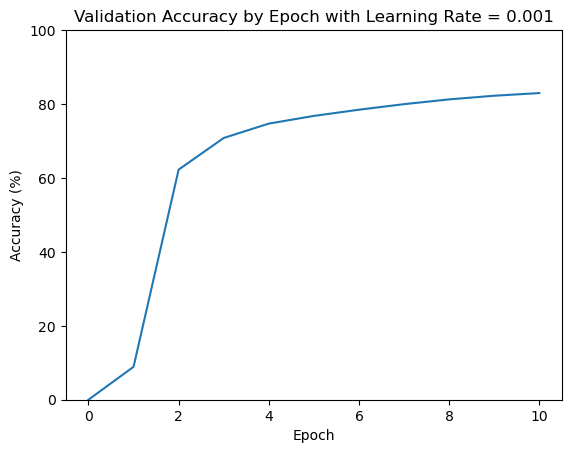

In [32]:
plt.ylim(0, 100)
plt.plot(acc_dict.values())
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy by Epoch with Learning Rate = 0.001')
plt.show()

In [33]:
# Test different learning rates
lr_list = [0.002, 0.02, 0.2]
acc_lr_dict = {}
for item in lr_list:
    acc_lr_dict[item], hidden_weights, output_weights = fit(train_X, train_y, test_X, test_y, lr=item)

Flattened Shapes: (60000, 784) (10000, 784) 

Epoch 1/10 Learning Rate: 0.002 Training Accuracy: 9.38% Training Error: 90.62% Test Accuracy: 10.76% Test Error: 89.24%
Epoch 2/10 Learning Rate: 0.002 Training Accuracy: 72.66% Training Error: 27.34% Test Accuracy: 72.37% Test Error: 27.63%
Epoch 3/10 Learning Rate: 0.002 Training Accuracy: 80.47% Training Error: 19.53% Test Accuracy: 78.41% Test Error: 21.59%
Epoch 4/10 Learning Rate: 0.002 Training Accuracy: 75.78% Training Error: 24.22% Test Accuracy: 81.75% Test Error: 18.25%
Epoch 5/10 Learning Rate: 0.002 Training Accuracy: 83.59% Training Error: 16.41% Test Accuracy: 83.54% Test Error: 16.46%
Epoch 6/10 Learning Rate: 0.002 Training Accuracy: 89.06% Training Error: 10.94% Test Accuracy: 84.46% Test Error: 15.54%
Epoch 7/10 Learning Rate: 0.002 Training Accuracy: 85.94% Training Error: 14.06% Test Accuracy: 84.68% Test Error: 15.32%
Epoch 8/10 Learning Rate: 0.002 Training Accuracy: 87.50% Training Error: 12.50% Test Accuracy: 84.90

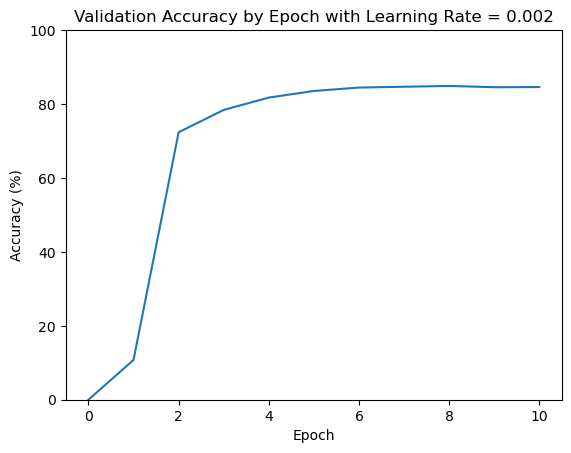

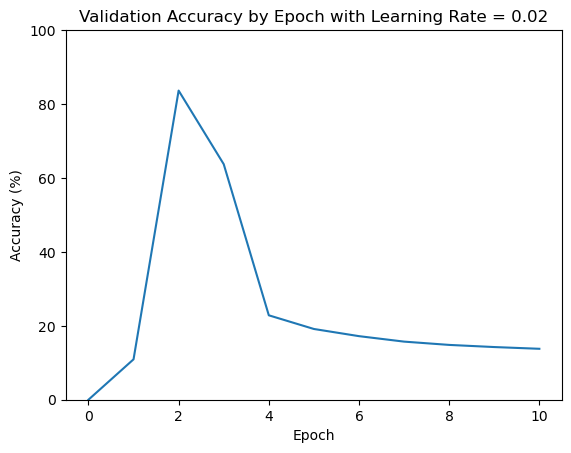

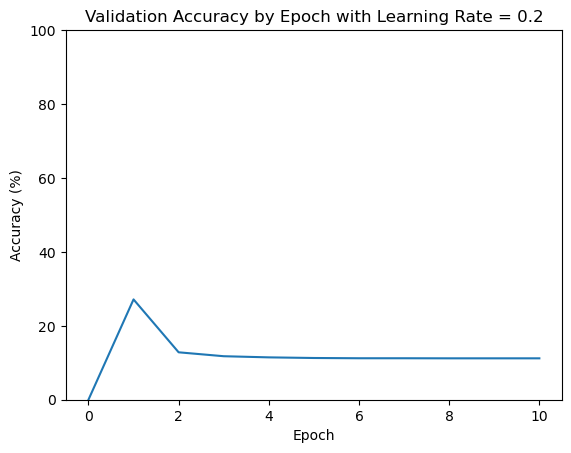

In [34]:
for lr, lr_info in acc_lr_dict.items():
    
    plt.ylim(0, 100)
    plt.plot(lr_info.values())
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy by Epoch with Learning Rate = {}'.format(lr))
    plt.show()

Accuracy typically increased as the number of gradient descents iterations and epochs took place. However, when the learning parameter is too large a value, the accuracy is a very poor number. 

## 1.3 Keras

In [4]:
# The kernel crashes so it must be started here
import time
import keras
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [6]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28, 1)),
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
keras_start = time.time()
print(model.fit(X_train, y_train, batch_size=784, epochs=10, validation_data=(X_test, y_test)))
print("\nTotal Time: {:.2f}s".format(time.time() - keras_start))

misclassified_images['1.3 Keras'] = np.where(test_y != np.argmax(model.predict(test_X), axis=-1))[0]

Epoch 1/10
77/77 [==============================] - 1s 7ms/step - loss: 0.7691 - accuracy: 0.8010 - val_loss: 0.4289 - val_accuracy: 0.8895
Epoch 2/10
77/77 [==============================] - 0s 3ms/step - loss: 0.3680 - accuracy: 0.8998 - val_loss: 0.3109 - val_accuracy: 0.9172
Epoch 3/10
77/77 [==============================] - 0s 3ms/step - loss: 0.2908 - accuracy: 0.9179 - val_loss: 0.2581 - val_accuracy: 0.9254
Epoch 4/10
77/77 [==============================] - 0s 3ms/step - loss: 0.2527 - accuracy: 0.9272 - val_loss: 0.2373 - val_accuracy: 0.9321
Epoch 5/10
77/77 [==============================] - 0s 3ms/step - loss: 0.2277 - accuracy: 0.9345 - val_loss: 0.2221 - val_accuracy: 0.9349
Epoch 6/10
77/77 [==============================] - 0s 3ms/step - loss: 0.2106 - accuracy: 0.9385 - val_loss: 0.2025 - val_accuracy: 0.9408
Epoch 7/10
77/77 [==============================] - 0s 3ms/step - loss: 0.1970 - accuracy: 0.9424 - val_loss: 0.1919 - val_accuracy: 0.9432
Epoch 8/10
77/77 [==

Keras is much faster at 2.88s compared to ~12 seconds with the exact same network. It is also much more accurate with validation scores in ~89 - 94% range compared to  ~84% in the same network. 

## 1.4 ReLU

In [7]:
import time
import keras
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [9]:
reLU_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28, 1)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

reLU_model.compile(loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

reLU_start = time.time()
print(reLU_model.fit(X_train, y_train, batch_size=784, epochs=10, validation_data=(X_test, y_test)))
print("\nTotal Time: {:.2f}s".format(time.time() - reLU_start))

misclassified_images['1.4 ReLU'] = np.where(test_y != np.argmax(reLU_model.predict(test_X), axis=-1))[0]

Epoch 1/10
77/77 [==============================] - 1s 5ms/step - loss: 15.3417 - accuracy: 0.7746 - val_loss: 3.6903 - val_accuracy: 0.8948
Epoch 2/10
77/77 [==============================] - 0s 3ms/step - loss: 2.4749 - accuracy: 0.9056 - val_loss: 1.8098 - val_accuracy: 0.9201
Epoch 3/10
77/77 [==============================] - 0s 3ms/step - loss: 1.1252 - accuracy: 0.9339 - val_loss: 1.1247 - val_accuracy: 0.9299
Epoch 4/10
77/77 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.9462 - val_loss: 1.1953 - val_accuracy: 0.9120
Epoch 5/10
77/77 [==============================] - 0s 3ms/step - loss: 0.4228 - accuracy: 0.9544 - val_loss: 0.8590 - val_accuracy: 0.9291
Epoch 6/10
77/77 [==============================] - 0s 3ms/step - loss: 0.3072 - accuracy: 0.9621 - val_loss: 0.7444 - val_accuracy: 0.9400
Epoch 7/10
77/77 [==============================] - 0s 3ms/step - loss: 0.2335 - accuracy: 0.9683 - val_loss: 0.5949 - val_accuracy: 0.9501
Epoch 8/10
77/77 [=

Compared to the sigmoid model above, the results are very similar in terms of accuracy and time per epoch. However, the loss is quite different. 

## 1.5 Dropout

In [10]:
import time
import keras
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV, KFold
from keras.wrappers.scikit_learn import KerasClassifier
import warnings

In [11]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [12]:
def NN(dropout_rate, l2_regularizer):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(10, activation='softmax', kernel_regularizer=keras.regularizers.l2(l2_regularizer), bias_regularizer=keras.regularizers.l2(l2_regularizer))
    ])
    model.compile(loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return model

In [13]:
# Suppress DeprecationWarning
warnings.simplefilter(action='ignore', category=DeprecationWarning)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# A good dropout value in hidden layers is between 0.5 and 0.8, input layer is 0.8
# https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
dropout_rates = [0.0, 0.4, 0.8]
L2_params = [0.0, 0.4, 0.8]

param_grid = dict(dropout_rate=dropout_rates, l2_regularizer=L2_params)

drop_start = time.time()
tuning_model = KerasClassifier(build_fn=NN, batch_size=784, epochs=10, verbose=0,)

models = GridSearchCV(estimator=tuning_model, param_grid=param_grid, cv=KFold(2), verbose=10)

results = models.fit(X_train, y_train)
best_drop_rate = results.best_params_['dropout_rate']
best_l2 = results.best_params_['l2_regularizer']

dropout_model = NN(best_drop_rate, best_l2)

print("\nFitting with best hyperparamters: dropout_rate: {}, l2_regularizer: {}".format(best_drop_rate, best_l2))
print(dropout_model.fit(X_train, y_train, batch_size=784, epochs=10, validation_data=(X_test, y_test)))
print("\nTotal Time: {:.2f}s".format(time.time() - drop_start))

misclassified_images['1.5 Dropout'] = np.where(test_y != np.argmax(dropout_model.predict(test_X), axis=-1))[0]

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2; 1/9] START dropout_rate=0.0, l2_regularizer=0.0........................
[CV 1/2; 1/9] END dropout_rate=0.0, l2_regularizer=0.0;, score=0.921 total time=   1.9s
[CV 2/2; 1/9] START dropout_rate=0.0, l2_regularizer=0.0........................
[CV 2/2; 1/9] END dropout_rate=0.0, l2_regularizer=0.0;, score=0.911 total time=   2.1s
[CV 1/2; 2/9] START dropout_rate=0.0, l2_regularizer=0.4........................
[CV 1/2; 2/9] END dropout_rate=0.0, l2_regularizer=0.4;, score=0.929 total time=   2.1s
[CV 2/2; 2/9] START dropout_rate=0.0, l2_regularizer=0.4........................
[CV 2/2; 2/9] END dropout_rate=0.0, l2_regularizer=0.4;, score=0.953 total time=   1.9s
[CV 1/2; 3/9] START dropout_rate=0.0, l2_regularizer=0.8........................
[CV 1/2; 3/9] END dropout_rate=0.0, l2_regularizer=0.8;, score=0.948 total time=   2.0s
[CV 2/2; 3/9] START dropout_rate=0.0, l2_regularizer=0.8........................
[CV 2/2; 3/9] 

Adding hyperparameters gave us a slightly better accuracy of ~96% compared to that of ~95% from the previous example. It was interesting to see the best dropout_rate being 0.0. This contradicts what I read and linked above stating that the best dropout_rate for hidden layers was between 0.5 and 0.8. 

## 1.6 Convolution

In [14]:
import time
import keras
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [15]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [16]:
# Make sure images have shape (28, 28, 1)
train_X = np.expand_dims(X_train, -1)
test_X = np.expand_dims(X_test, -1)
print(train_X.shape, test_X.shape)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

conv_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(input_shape=(28, 28, 1)),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.0),
    keras.layers.Dense(10, activation='softmax')
])

conv_model.compile(loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

conv_time = time.time()

print(conv_model.fit(train_X, y_train, batch_size=784, epochs=10, validation_data=(test_X, y_test)))
print("\nTotal Time: {:.2f}s".format(time.time() - conv_time))

misclassified_images['1.6 Convolution'] = np.where(test_y != np.argmax(conv_model.predict(test_X), axis=-1))[0]

(60000, 28, 28, 1) (10000, 28, 28, 1)
Epoch 1/10
77/77 [==============================] - 5s 58ms/step - loss: 8.6836 - accuracy: 0.7119 - val_loss: 0.3342 - val_accuracy: 0.8969
Epoch 2/10
77/77 [==============================] - 4s 56ms/step - loss: 0.4857 - accuracy: 0.8754 - val_loss: 0.1576 - val_accuracy: 0.9521
Epoch 3/10
77/77 [==============================] - 4s 55ms/step - loss: 0.2710 - accuracy: 0.9240 - val_loss: 0.1014 - val_accuracy: 0.9687
Epoch 4/10
77/77 [==============================] - 4s 56ms/step - loss: 0.2070 - accuracy: 0.9414 - val_loss: 0.0771 - val_accuracy: 0.9767
Epoch 5/10
77/77 [==============================] - 4s 57ms/step - loss: 0.1743 - accuracy: 0.9504 - val_loss: 0.0703 - val_accuracy: 0.9794
Epoch 6/10
77/77 [==============================] - 4s 55ms/step - loss: 0.1512 - accuracy: 0.9567 - val_loss: 0.0624 - val_accuracy: 0.9817
Epoch 7/10
77/77 [==============================] - 4s 55ms/step - loss: 0.1381 - accuracy: 0.9594 - val_loss: 0.060

Compared to 1.5, accuracy increased ~2%. I decided to use the best dropout rate from 1.5 which is 0.0 on the hidden layer, and a dropout_rate of 0.8 on the input layer. I tried to test 0.5 on the hidden layer, but the accuracy was surprisingly less than 1.5.

## 1.7 Mugshots

In [45]:
from functools import reduce
from keras.datasets import mnist

In [46]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
conv_test_X = np.expand_dims(X_train, -1)


Actual Class: 4
Simple Model Predicted Class: 0
Keras Model Predicted Class: 6
ReLU Model Predicted Class: 2
Dropout Model Predicted Class: 2
Conv Model Predicted Class: 9


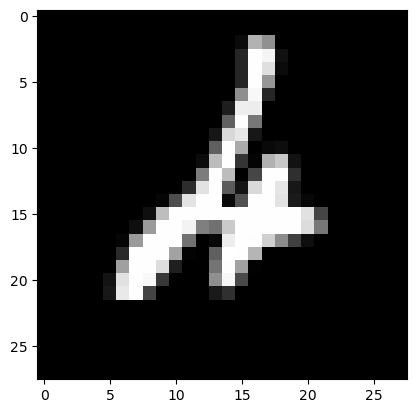


Actual Class: 2
Simple Model Predicted Class: 0
Keras Model Predicted Class: 7
ReLU Model Predicted Class: 7
Dropout Model Predicted Class: 7
Conv Model Predicted Class: 3


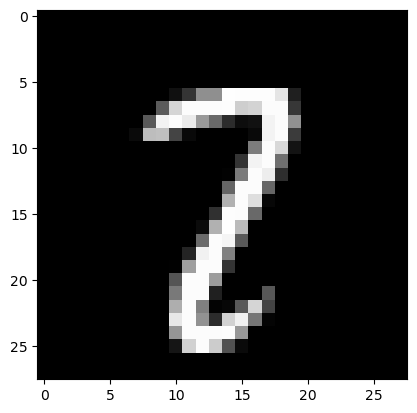


Actual Class: 6
Simple Model Predicted Class: 0
Keras Model Predicted Class: 0
ReLU Model Predicted Class: 0
Dropout Model Predicted Class: 0
Conv Model Predicted Class: 8


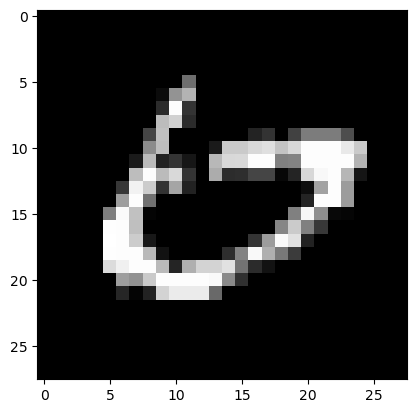


Actual Class: 1
Simple Model Predicted Class: 0
Keras Model Predicted Class: 8
ReLU Model Predicted Class: 8
Dropout Model Predicted Class: 8
Conv Model Predicted Class: 2


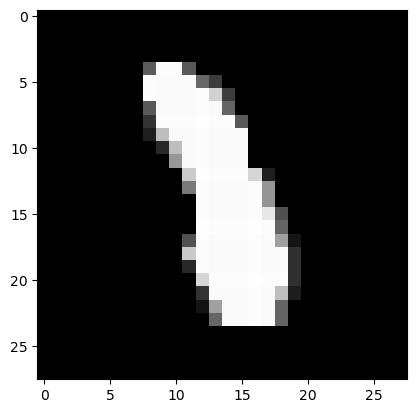


Actual Class: 2
Simple Model Predicted Class: 0
Keras Model Predicted Class: 7
ReLU Model Predicted Class: 7
Dropout Model Predicted Class: 3
Conv Model Predicted Class: 5


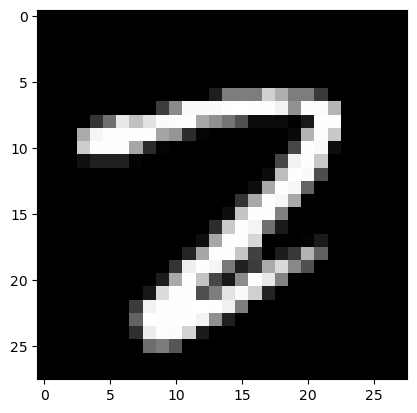


Actual Class: 6
Simple Model Predicted Class: 0
Keras Model Predicted Class: 5
ReLU Model Predicted Class: 5
Dropout Model Predicted Class: 5
Conv Model Predicted Class: 7


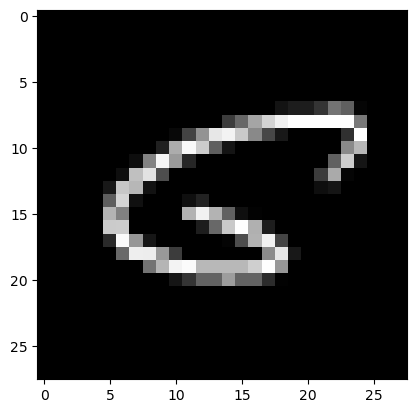


Actual Class: 7
Simple Model Predicted Class: 0
Keras Model Predicted Class: 1
ReLU Model Predicted Class: 2
Dropout Model Predicted Class: 8
Conv Model Predicted Class: 5


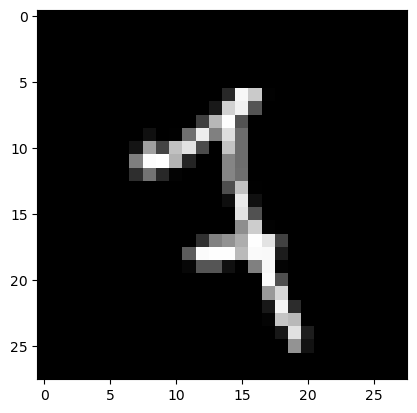


Actual Class: 4
Simple Model Predicted Class: 0
Keras Model Predicted Class: 6
ReLU Model Predicted Class: 6
Dropout Model Predicted Class: 6
Conv Model Predicted Class: 9


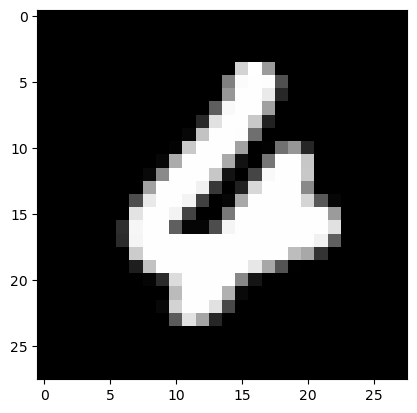


Actual Class: 7
Simple Model Predicted Class: 0
Keras Model Predicted Class: 2
ReLU Model Predicted Class: 2
Dropout Model Predicted Class: 2
Conv Model Predicted Class: 3


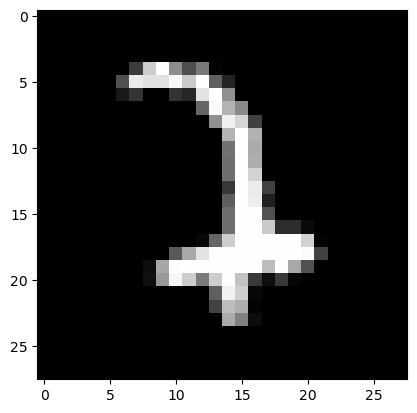

In [48]:
misclassified = reduce(np.intersect1d, (misclassified_images['1.2 Simple'], 
                                        misclassified_images['1.3 Keras'],
                                        misclassified_images['1.4 ReLU'],
                                        misclassified_images['1.5 Dropout'],
                                        misclassified_images['1.6 Convolution']
                                       ))


for i in range(0, 9):
    plt.imshow(X_test[misclassified[i]], cmap='gray')
    simple_img = X_test[misclassified[i]].reshape((-1, 784))
    # Keras reLU and Dropout models must have this specific shape
    k_r_d_img_idx = X_test[misclassified[i]].reshape((1, 28, 28))
    
    keras_pred = np.argmax(model.predict(k_r_d_img_idx), axis=-1)[0]
    reLU_pred = np.argmax(reLU_model.predict(k_r_d_img_idx), axis=-1)[0]
    dropout_pred = np.argmax(dropout_model.predict(k_r_d_img_idx), axis=-1)[0]
    conv_pred = np.argmax(conv_model.predict(conv_test_X[np.expand_dims(misclassified[i], -1)]), axis=-1)[0]
    # 1.2 has be last or the kernel crashes
    simple_pred = prediction(simple_img, hidden_weights, output_weights)[0]
    
    actual_value = np.argmax(y_test[misclassified[i]], axis=-1)
    print("\nActual Class:", actual_value)
    print("Simple Model Predicted Class:", simple_pred)
    print("Keras Model Predicted Class:", keras_pred)
    print("ReLU Model Predicted Class:", reLU_pred)
    print("Dropout Model Predicted Class:", dropout_pred)
    print("Conv Model Predicted Class:", conv_pred)
    plt.show()

I am able to classify some of these images myself, however, they are quite difficult and sometimes it is necessary to take a best guess. 